In [1]:
import Bio.bgzf as bgzf
import pysam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.stats.api as sms
import scipy.stats as st
import seaborn as sns
from IPython.display import display, HTML
from time import time


from collections import defaultdict, Counter
import collections
from operator import itemgetter
from itertools import groupby
import re

# Домашка 3. minimap
### Данные
https://drive.google.com/drive/folders/1pD7PKCDXm2FeUWNeSD40r4WxU0BGdSbR

`ONT_2D.fastq.gz`

`acbio_40x.fq.gz`

Референсный геном: `reference.fasta`

### 0. Разобраться с minimap2
Запустить minimap2, определить процент приложившихся ридов (samtools flagstat).

install minimap2:
`
curl -L https://github.com/lh3/minimap2/releases/download/v2.17/minimap2-2.17_x64-linux.tar.bz2 | tar -jxvf - ./minimap2-2.17_x64-linux/minimap2
alias minimap2=~/minimap2-2.17_x64-linux/minimap2
`

### 1. Pacbio dataset

Запустим minimap2:
```
$ minimap2 --MD -H -a -t 4 data/reference.fasta data/pacbio_40x.fq.gz > data/pacbio.sam
[M::mm_idx_gen::0.167*1.02] collected minimizers
[M::mm_idx_gen::0.224*1.75] sorted minimizers
[M::main::0.224*1.75] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.236*1.71] mid_occ = 12
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.244*1.69] distinct minimizers: 513422 (82.88% are singletons); average occurrences: 1.235; average spacing: 7.318
[M::worker_pipeline::64.987*3.62] mapped 41447 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: /home/toharhymes/minimap2-2.17_x64-linux/minimap2 --MD -H -a -t 4 data/reference.fasta data/pacbio_40x.fq.gz
[M::main] Real time: 65.004 sec; CPU: 235.453 sec; Peak RSS: 1.681 GB

$ samtools flagstat data/pacbio.sam
52242 + 0 in total (QC-passed reads + QC-failed reads)
1701 + 0 secondary
9094 + 0 supplementary
0 + 0 duplicates
51645 + 0 mapped (98.86% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

$ samtools view -S -b data/pacbio.sam > data/pacbio.bam

```

#### Посчитать статистики из задания 2 для ридов PacBio и Oxford Nanopores:
* Покрытие генома
* Процент ошибок
* Распределение типов замен
* Распределение длин инделов

Сравнить результаты.

Хочу переписать функции из дз 2, так как там оч много чего коряво и костыльно (не знал многих методов).

In [2]:
def read_bam(path_to_bam):
    return pysam.AlignmentFile(path_to_bam, "rb")

def read_sam(path_to_sam):
    return pysam.AlignmentFile(path_to_sam, "r")

In [3]:
def cov_stat(cov):
    avg = np.mean(cov)
    zero_amount = np.count_nonzero(avg == 0)
    part_of_cov = 1 - zero_amount/len(cov)
    return avg, part_of_cov

def draw_coverage(cov):
    plt.plot([i*1000 for i in range(len(cov))], cov, linestyle="-", color = 'red')
    plt.show()
    
def count_cov(sam, step=10000):
    ln_ref = sam.get_reference_length(sam.references[0])
    starts = []
    ends = []
    for read in sam:
            if not read.is_unmapped:
                starts.append([read.reference_start, 'start'])
                ends.append([read.reference_end, 'end'])
    starts.sort()
    ends.sort()
    both = sorted(starts+ ends)
    covs = []
    cur_cov = 0
    cur_pos = -1
    for pos, start_or_end in both:
        if cur_pos // step != pos // step:
            cur_pos = pos
            covs.append(cur_cov)
        if start_or_end == 'start':
            cur_cov += 1
        else:
            cur_cov -= 1
    avg, part_of_cov = cov_stat(covs)
    print('Среднее покрытие:', avg)
    print('Доля покрытия', part_of_cov)
    draw_coverage(covs)

In [4]:
# ошибки в ридах    
def errors(bam_file_path):
    
    tic = time()
    bam_file = pysam.AlignmentFile(bam_file_path, 'rb')
    
    # счетчики ошибок и мисматчей, общей длины ридов и количества ридов
    error_counter = 0
    mismatch_counter = 0
    reference_length = 0
    file_length = 0

    # счетчик длин инделов
    insertions = defaultdict(int)
    deletions = defaultdict(int)
    
    #ДЛЯ ЗАМЕН
    letter_to_digit = {'A':0, 'C':1, 'G':2, 'T':3}
    digit_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
    substitutions = [[0 for x in range(4)] for y in range(4)]
    try:
        for read in bam_file:
            if read.is_unmapped or read.is_supplementary or not read.has_tag('MD'): 
                continue
            try:
                seq = read.seq
                ref_seq = read.get_reference_sequence()
                cigar = read.cigarstring
            except TypeError:
                continue
            # В seq не учитывается 'D'
            # В ref_seq не учитывается 'I', 'S'
            # В quality - 'S' и 'D'
            pivot = 0
            d_counter = 0
            i_counter = 0
            s_counter = 0

            for num, letter in re.findall('(\d+)([A-Za-z])', cigar):
                num = int(num)
                if letter == 'I':
                    begin = pivot - s_counter - d_counter
                    insertions[num] += 1
                    i_counter += num
                elif letter == 'D':
                    b_ref = pivot - i_counter - s_counter
                    deletions[num] += 1
                    d_counter += num
                elif letter == 'M':
                    b_seq = pivot - d_counter
                    b_ref = pivot - i_counter - s_counter
                    b_qual = pivot - s_counter - d_counter
                    for seq_l, ref_l in zip(seq[b_seq:b_seq+num], ref_seq[b_ref:b_ref+num]):
                        if seq_l.upper() != ref_l.upper():
                            mismatch_counter += 1
                            substitutions[letter_to_digit[seq_l.upper()]][letter_to_digit[ref_l.upper()]]+=1
                elif letter == 'S':
                    s_counter += num        
                pivot += num


            if file_length%10000 == 0:
                print(file_length, end = ' ')
                print(f'{time()-tic} sec', end = ' ')
            reference_length += pivot
            file_length += 1
            error_counter += i_counter+d_counter
    except KeyboardInterrupt:
        pass
    error_counter += mismatch_counter              

    def average_indels(dictionary, read_amount, reads_length, name:str):
        amount = 0
        indel_len = []
        indel_freq = []
        od = collections.OrderedDict(sorted(dictionary.items()))
        for key in od:
            if key < 300:
                amount += od[key]*key
                indel_len.append(key)
                indel_freq.append(od[key]/read_amount)
        print(f'Statistics of {name}')
        plt.plot(indel_len,indel_freq)
        plt.yscale('log')
        plt.show()
        return amount
    
    def to_df(substitutions):
        numpy_data = np.array(substitutions)
        df = pd.DataFrame(data=numpy_data, index=['A', 'C', 'G', 'T'], columns=['A', 'C', 'G', 'T'])
        return df

    percentage_of_errors = error_counter/reference_length
    print()
    print(f'Average errors percentage: {percentage_of_errors*100}%')
    print('---')
    insertions_amount = average_indels(insertions, file_length, reference_length, 'insertions')
    deletions_amount = average_indels(deletions, file_length, reference_length, 'deletions')
    print('---')
    print(f'Total frequency of insertions = {insertions_amount/reference_length}')
    print(f'Total frequency of deletions = {deletions_amount/reference_length}')
    print(f'Total frequency of mismatches = {mismatch_counter/reference_length}')
    print('---')
    print('SUBSTITUTIONS')
    print(to_df(substitutions))

In [5]:
def run(bam):
    # ПОКРЫТИЕ
    print('COVERAGE\n')
    # Посчитаем покрытие и статистики
    bam_file_pacbio = read_bam(bam)
    count_cov(bam_file_pacbio)
    print('=====================')
    # ОШИБКИ и ЗАМЕНЫ
    print('\nERRORS\n')
    errors(bam)


COVERAGE

Среднее покрытие: 40.525862068965516
Доля покрытия 1.0


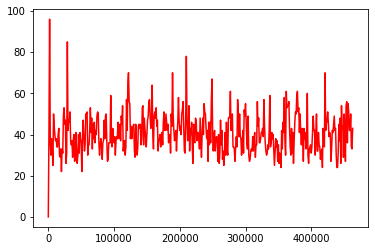


ERRORS

0 0.0017757415771484375 sec 10000 19.260538578033447 sec 20000 37.794944524765015 sec 30000 56.6098256111145 sec 40000 75.4187445640564 sec 
Average errors percentage: 12.348289690589805%
---
Statistics of insertions


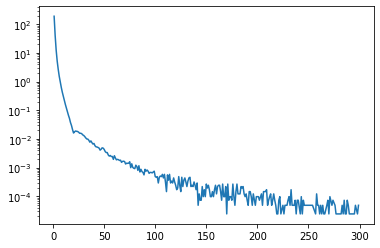

Statistics of deletions


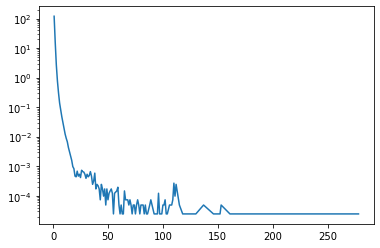

---
Total frequency of insertions = 0.07377128354204936
Total frequency of deletions = 0.03040734333313927
Total frequency of mismatches = 0.018637250532600128
---
SUBSTITUTIONS
        A       C       G       T
A       0  447907  315202  278642
C  344171       0  405602  300801
G  299288  404479       0  350115
T  279530  315654  441334       0


In [6]:
run('data/pacbio.bam')

### 2. Nanopore

Запустим minimap2:
```
$ minimap2 --MD -a -t 4 data/reference.fasta data/ONT_2D.fastq.gz > data/ONT.sam
[M::mm_idx_gen::0.151*1.02] collected minimizers
[M::mm_idx_gen::0.226*1.97] sorted minimizers
[M::main::0.226*1.97] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.262*1.83] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.274*1.80] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.034; average spacing: 5.352
[M::worker_pipeline::22.101*3.42] mapped 30810 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: /home/toharhymes/minimap2-2.17_x64-linux/minimap2 --MD -a -t 4 data/reference.fasta data/ONT_2D.fastq.gz
[M::main] Real time: 22.109 sec; CPU: 75.588 sec; Peak RSS: 1.062 GB

$ samtools flagstat data/ONT.sam
32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)
$ samtools view -S -b data/ONT.sam > data/ONT.bam

```

COVERAGE

Среднее покрытие: 28.316810344827587
Доля покрытия 1.0


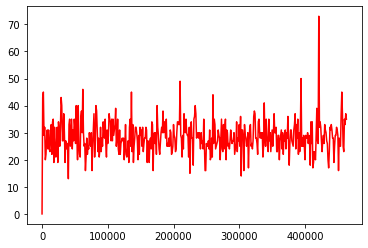


ERRORS

0 0.0007917881011962891 sec 10000 12.839329719543457 sec 20000 25.67222547531128 sec 
Average errors percentage: 7.5570417552448115%
---
Statistics of insertions


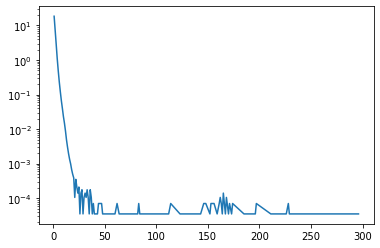

Statistics of deletions


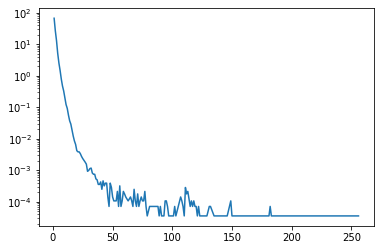

---
Total frequency of insertions = 0.011180015999732352
Total frequency of deletions = 0.04704065763488
Total frequency of mismatches = 0.016933056310009055
---
SUBSTITUTIONS
        A       C       G       T
A       0  135983  317694  106681
C  111793       0   90403  370667
G  366343   84140       0  110296
T  104257  338748  125395       0


In [7]:
run('data/ONT.bam')

Выводы:
* у пакбио больший разброс покрытия, нежели чем у нанопор.
* Процент ошибок у Pacbio больше, чем у nanopore (12,3% против 7,5%), мисмачей и делечий примерно одинаковая частота, а вот инсерции у пакбио встречаются в 7 раз чаще (из графика видно, что они у них длиннее).
